In [4]:
%matplotlib inline

import numpy as np                     # Numerical algorithms on arrays
import cv2                             # OpenCV
from matplotlib import pyplot as plt   # Plot library
import matplotlib.cm as cm             # Image color map 
import tools                           # A few helpers to plot multiple images
from PIL import Image                  # For rescaling images
from ipywidgets import interact, fixed # Interact with images
import pandas as pd

In [5]:
img_link = 'images/soccer_1.png'

annotation_link = 'annotations/soccer_1.txt'

In [6]:
data = pd.read_csv(annotation_link, header=None)

x1_annot = []
y1_annot = []
x2_annot = []
y2_annot = []

img = cv2.imread(img_link, cv2.IMREAD_GRAYSCALE)
height, width = img.shape[:2]

H=height

for _, row in data.iterrows():
    x1_annot.append(int(row[0]))
    y1_annot.append(int(row[1]))
    x2_annot.append(int(row[2]))
    y2_annot.append(int(row[3]))

print(x1_annot,y1_annot,H)
    
number_lines = len(row)

[1183, 1180, 618, 3, 2, 0] [556, 556, 586, 579, 547, 529] 720


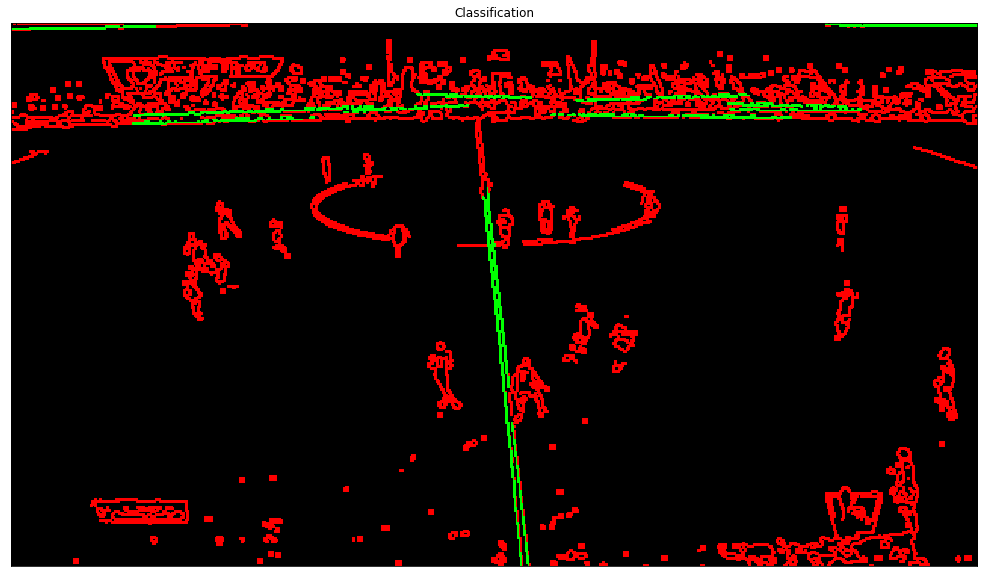

In [7]:
# for soccer classification

img = cv2.imread(img_link, cv2.IMREAD_GRAYSCALE)

iGausKernelSize = 7
imgFilt = cv2.GaussianBlur(img, (iGausKernelSize, iGausKernelSize), 0)
_, imgThres = cv2.threshold(imgFilt, 0, 255, cv2.THRESH_TOZERO+cv2.THRESH_OTSU)
iReducFactor = 2
iStart = iReducFactor // 2
imgReduc = imgThres[iStart::iReducFactor, iStart::iReducFactor]

med = np.median( imgReduc)
    
# apply automatic Canny edge detection using the computed median
sigma = 0.3
loThreshold = int( max( 0, (1.0 - sigma) * med))
hiThreshold = int( min( 255, (1.0 + sigma) * med))

edges_canny = cv2.Canny( imgReduc, loThreshold, hiThreshold, apertureSize=3, L2gradient=False)
edges = cv2.dilate(edges_canny, np.ones((2,2), dtype=np.uint8))

Max_gap = 2
Min_length = 75
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,np.array([]),Min_length,Max_gap)
for l in lines:
    for x1,y1,x2,y2 in l:
        cv2.line(img,(2*x1,2*y1),(2*x2,2*y2),(0,255,0),3)
height, width = img.shape[:2]
mat = np.zeros((height,width))

lines = cv2.HoughLinesP(edges,1,np.pi/180,100,np.array([]),Min_length,Max_gap)
for l in lines:
    for x1,y1,x2,y2 in l:
        cv2.line(mat,(2*x1,2*y1),(2*x2,2*y2),(255,255,255),3) 

iReducFactor = 2
iStart = iReducFactor // 2
blackReduc = mat[iStart::iReducFactor, iStart::iReducFactor]
blackReduc = blackReduc.astype('uint8')

img_and = cv2.bitwise_and(blackReduc, edges)

img_and_canny = cv2.bitwise_and(blackReduc, edges_canny)

edges_negative_undilated = edges_canny - img_and_canny

edges_negative = cv2.dilate(edges_canny, np.ones((2,2), dtype=np.uint8))

dilated = cv2.dilate(img_and, np.ones((1,1), dtype=np.uint8))
colored = np.zeros((dilated.shape[0], dilated.shape[1], 3), dtype='uint8')

colored[:,:,0] = edges
colored[:,:,0] -= dilated
colored[:,:,1] = dilated

tools.multiPlot(1, 1, (colored,), ('Classification',), cmap_tuple=(cm.gray,))

Pourcent of true positive pixels =  4.769902586496473 %
Pourcent of false positive pixels =  95.23009741350353 %
Pourcent of true negative pixels =  98.94728415322419 %
Pourcent of false negative pixels =  1.0527158467758075 %
0 over 16 lines have been correctly detected


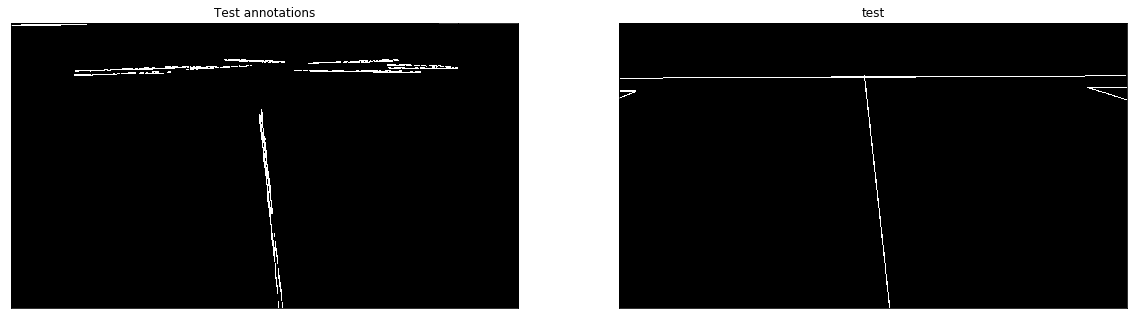

In [9]:
#height, width = img.shape[:2]
mat_annotations1 = np.zeros((height,width))

img_color = cv2.imread(img_link, cv2.IMREAD_COLOR)

b,g,r = cv2.split(img_color)
img_color = cv2.merge( [r,g,b])


#lines_annotations = lines#output of the annotations (expect a vector containing x1,y1,x2,y2 the coordinates of the vector ends)
for i in range(len(x1_annot)):
    cv2.line(mat_annotations1,(int(x1_annot[i]),H-int(y1_annot[i])),(int(x2_annot[i]),H-int(y2_annot[i])),(255, 255, 255),2) #peut-etre changer le 2*
    #cv2.line(img_color,(2*x1,2*y1),(2*x2,2*y2),(255,0,0),3) 

        
#Comparison between adaptive threshold and annotations
        
iReducFactor = 2
iStart = iReducFactor // 2
blackReduc_annotations = mat_annotations1[iStart::iReducFactor, iStart::iReducFactor]

blackReduc_annotations = blackReduc_annotations.astype('uint8') #photo noire contenant toutes les droites tracees dans les annotations

blackReduc_annotations_invert = (255-blackReduc_annotations)

true_positive = cv2.bitwise_and(img_and, blackReduc_annotations)

false_positive = cv2.bitwise_and(img_and, blackReduc_annotations_invert)

true_negative = cv2.bitwise_and(edges_negative, blackReduc_annotations_invert)

false_negative = cv2.bitwise_and(edges_negative, blackReduc_annotations)

num_pixels_detected_pos = cv2.countNonZero(img_and)

num_pixels_detected_neg = cv2.countNonZero(edges_negative)

num_true_positive = cv2.countNonZero(true_positive)

num_false_positive = cv2.countNonZero(false_positive)

num_true_negative = cv2.countNonZero(true_negative)

num_false_negative = cv2.countNonZero(false_negative)

pourcent_true_pos = num_true_positive/num_pixels_detected_pos

pourcent_false_pos = num_false_positive/num_pixels_detected_pos

pourcent_true_neg = num_true_negative/num_pixels_detected_neg

pourcent_false_neg = num_false_negative/num_pixels_detected_neg

print("Pourcent of true positive pixels = ", pourcent_true_pos*100, "%")
print("Pourcent of false positive pixels = ", pourcent_false_pos*100, "%")

print("Pourcent of true negative pixels = ", pourcent_true_neg*100, "%")
print("Pourcent of false negative pixels = ", pourcent_false_neg*100, "%")

#Comparison between Hough and annotations

good_lines_detected = 0
i=0
for ll in lines :
    mat = np.zeros((height,width))
    for x11,y11,x22,y22 in ll: 
        cv2.line(mat,(2*x11,2*y11),(2*x22,2*y22),(255, 255, 255),3)
        pixels_Hough=cv2.countNonZero(mat)
        num_pixels_in_common = cv2.countNonZero(cv2.bitwise_and(mat_annotations1, mat))
        #if num_pixels_in_common > 2000 :
        #    print(num_pixels_in_common,i)
        #    i=i+1
        if (num_pixels_in_common > 0.5*pixels_Hough): # or num_pixels_in_common > 0.5*pixels_annotations): 
            good_lines_detected = good_lines_detected + 1

print(good_lines_detected, "over", len(lines), "lines have been correctly detected")   

tools.multiPlot(1, 2, (img_and,mat_annotations1),
                        ('Test annotations','test'),
                        cmap_tuple=(cm.gray,cm.gray))